In [1]:
import pickle
import pandas as pd
import os
from PIL import Image
from tqdm import tqdm
import torch
import timm
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from transformers import BartTokenizer, BartForConditionalGeneration
import torch.optim as optim
from torch.utils.data import DataLoader
import json

# Load train and validation TSV files
train_tsv = '/kaggle/input/more-dataset/train_df.tsv'
val_tsv = '/kaggle/input/more-dataset/val_df.tsv'
train_df = pd.read_csv(train_tsv, sep='\t')
val_df = pd.read_csv(val_tsv, sep='\t')

# Define image folder and extension
image_folder = "/kaggle/input/more-dataset/images"
image_extension = ".jpg"

# Device and Vision Transformer (ViT) setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
vit_model = timm.create_model("vit_base_patch16_224", pretrained=True)
vit_model = torch.nn.Sequential(*list(vit_model.children())[:-1])  # Remove classifier head
vit_model.to(device)
vit_model.eval()

# Image transform for feature extraction
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Extract features for train set
features_column_train = []
for pid in tqdm(train_df["pid"], desc="Extracting train image features"):
    image_name = f"{pid}{image_extension}"
    image_path = os.path.join(image_folder, image_name)
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            features = vit_model(image).squeeze(0).cpu().numpy()
        features_column_train.append(features.tolist())
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        features_column_train.append([0] * 768)  # Default feature vector
train_df["features"] = features_column_train

# Extract features for validation set
features_column_val = []
for pid in tqdm(val_df["pid"], desc="Extracting validation image features"):
    image_name = f"{pid}{image_extension}"
    image_path = os.path.join(image_folder, image_name)
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            features = vit_model(image).squeeze(0).cpu().numpy()
        features_column_val.append(features.tolist())
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        features_column_val.append([0] * 768)  # Default feature vector
val_df["features"] = features_column_val

# Load pickle files
with open("/kaggle/input/more-dataset/D_train.pkl", "rb") as f:
    D_train = pickle.load(f)
with open("/kaggle/input/more-dataset/D_val.pkl", "rb") as f:
    D_val = pickle.load(f)
with open("/kaggle/input/more-dataset/O_train.pkl", "rb") as f:
    O_train = pickle.load(f)
with open("/kaggle/input/more-dataset/O_val.pkl", "rb") as f:
    O_val = pickle.load(f)

# Clean object data
from collections import OrderedDict

def safe_preprocess(text):
    return text.strip() if isinstance(text, str) else ""

O_train_cleaned = {}
O_val_cleaned = {}
for pid, obj in O_train.items():
    class_list = obj.get("classes", []) if isinstance(obj, dict) else []
    class_list_unique = list(OrderedDict.fromkeys(class_list))
    O_train_cleaned[pid] = safe_preprocess(" ".join(class_list_unique))
for pid, obj in O_val.items():
    class_list = obj.get("classes", []) if isinstance(obj, dict) else []
    class_list_unique = list(OrderedDict.fromkeys(class_list))
    O_val_cleaned[pid] = safe_preprocess(" ".join(class_list_unique))

# Build T_knowledge column following Section 4.3 of the paper
t_knowledge_col = []
t_knowledge_col_val = []
for pid in train_df["pid"]:
    ci = train_df.loc[train_df["pid"] == pid, "text"].values[0]
    di = safe_preprocess(D_train.get(pid, ""))
    oi = O_train_cleaned.get(pid, "")
    ti = train_df.loc[train_df["pid"] == pid, "target_of_sarcasm"].values[0]
    t_knowledge = f"{ci} {di} {oi} </s> {ti}".strip()
    t_knowledge_col.append(t_knowledge)
for pid in val_df["pid"]:
    ci = val_df.loc[val_df["pid"] == pid, "text"].values[0]
    di = safe_preprocess(D_val.get(pid, ""))
    oi = O_val_cleaned.get(pid, "")
    ti = val_df.loc[val_df["pid"] == pid, "target_of_sarcasm"].values[0]
    t_knowledge = f"{ci} {di} {oi} </s> {ti}".strip()
    t_knowledge_col_val.append(t_knowledge)
train_df["T_knowledge"] = t_knowledge_col
val_df["T_knowledge"] = t_knowledge_col_val

Using device: cuda


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Extracting validation image features: 100%|██████████| 175/175 [00:07<00:00, 24.74it/s]


In [2]:
class SharedFusion(nn.Module):
    def __init__(self, dim):
        super(SharedFusion, self).__init__()
        self.dim = dim
        self.W_v = nn.Linear(dim, dim)
        self.W_t = nn.Linear(dim, dim)
        self.alpha1 = nn.Parameter(torch.tensor(0.25))
        self.alpha2 = nn.Parameter(torch.tensor(0.25))
        self.beta1 = nn.Parameter(torch.tensor(0.25))
        self.beta2 = nn.Parameter(torch.tensor(0.25))

    def forward(self, Ev, Et):
        Av = self.self_attention(Ev)
        At = self.self_attention(Et)
        if Ev.ndim == 3:
            Ev = Ev.mean(dim=1)
        if Av.ndim == 3:
            Av = Av.mean(dim=1)
        Fvt = At * Ev
        Ftv = Av * Et
        Gv = torch.sigmoid(self.W_v(Ev))
        Gt = torch.sigmoid(self.W_t(Et))
        F1 = Gv * Fvt + (1 - Gv) * Ev
        F2 = Gv * Ev + (1 - Gv) * Fvt
        Fv = Gv * Ev + (1 - Gv) * Ftv
        Ft = Gt * Et + (1 - Gt) * Fvt
        F_SF = self.alpha1 * F1 + self.alpha2 * F2 + self.beta1 * Fv + self.beta2 * Ft
        return F_SF

    def self_attention(self, E):
        Q = K = V = E.unsqueeze(1)  # [B, 1, D]
        dk = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(dk, dtype=torch.float32, device=E.device))
        weights = F.softmax(scores, dim=-1)
        A = torch.matmul(weights, V)  # [B, 1, D]
        return A.squeeze(1)

In [3]:

# Multimodal Sarcasm Explanation Model
class MultimodalSarcasmExplanationModel(nn.Module):
    def __init__(self, bart_model_name='facebook/bart-base', visual_dim=768, proj_dim=768):
        super(MultimodalSarcasmExplanationModel, self).__init__()
        self.bart = BartForConditionalGeneration.from_pretrained(bart_model_name)
        self.tokenizer = BartTokenizer.from_pretrained(bart_model_name)
        self.visual_projection = nn.Linear(visual_dim, proj_dim)
        self.shared_fusion = SharedFusion(dim=proj_dim)
        self.fusion_combine = nn.Linear(proj_dim * 2, proj_dim)
        self.to(device)

    def forward(self, input_ids, attention_mask, visual_features, labels=None):
        # Run the encoder
        encoder_outputs = self.bart.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = encoder_outputs.last_hidden_state[:, 0, :]  # [B, hidden_dim]
        
        # Process visual features and fuse with text
        visual_proj = self.visual_projection(visual_features)  # [B, hidden_dim]
        fused = self.shared_fusion(visual_proj, text_embed)  # [B, hidden_dim]
        combined = torch.cat([text_embed, fused], dim=-1)  # [B, 2*hidden_dim]
        combined = self.fusion_combine(combined)  # [B, hidden_dim]
        
        # Clone the tensor to avoid in-place modification
        new_last_hidden_state = encoder_outputs.last_hidden_state.clone()
        new_last_hidden_state[:, 0, :] = combined  # Modify the clone, not the original
        
        # Create a new encoder outputs object with the modified tensor
        modified_encoder_outputs = encoder_outputs.__class__(last_hidden_state=new_last_hidden_state)
        
        # Pass to the BART model
        outputs = self.bart(
            encoder_outputs=modified_encoder_outputs,
            attention_mask=attention_mask,
            labels=labels
        )
        return outputs

    def generate_explanation(self, input_ids, attention_mask, visual_features, **generate_kwargs):
        encoder_outputs = self.bart.model.encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embed = encoder_outputs.last_hidden_state[:, 0, :]
        visual_proj = self.visual_projection(visual_features)
        fused = self.shared_fusion(visual_proj, text_embed)
        combined = torch.cat([text_embed, fused], dim=-1)
        combined = self.fusion_combine(combined)
        encoder_outputs.last_hidden_state[:, 0, :] = combined
        generated_ids = self.bart.generate(
            encoder_outputs=encoder_outputs,
            attention_mask=attention_mask,
            **generate_kwargs
        )
        return generated_ids

In [4]:


# def compute_metrics(references, predictions):
#     # ROUGE
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
#     rouge_1, rouge_2, rouge_l = 0, 0, 0
#     for ref, pred in zip(references, predictions):
#         scores = scorer.score(ref, pred)
#         rouge_1 += scores['rouge1'].fmeasure
#         rouge_2 += scores['rouge2'].fmeasure
#         rouge_l += scores['rougeL'].fmeasure

#     # BLEU
#     smoothie = SmoothingFunction().method4
#     bleu_1 = sum([sentence_bleu([ref.split()], pred.split(), weights=(1, 0, 0, 0), smoothing_function=smoothie) for ref, pred in zip(references, predictions)])
#     bleu_2 = sum([sentence_bleu([ref.split()], pred.split(), weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie) for ref, pred in zip(references, predictions)])
#     bleu_3 = sum([sentence_bleu([ref.split()], pred.split(), weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie) for ref, pred in zip(references, predictions)])
#     bleu_4 = sum([sentence_bleu([ref.split()], pred.split(), weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) for ref, pred in zip(references, predictions)])

#     # METEOR
#     meteor = sum([meteor_score([ref], pred) for ref, pred in zip(references, predictions)])

#     # BERTScore
#     P, R, F1 = bert_score_fn(predictions, references, lang="en", rescale_with_baseline=True)
#     bert_f1 = F1.mean().item()

#     total = len(references)
#     return {
#         "ROUGE-1": rouge_1 / total,
#         "ROUGE-2": rouge_2 / total,
#         "ROUGE-L": rouge_l / total,
#         "BLEU-1": bleu_1 / total,
#         "BLEU-2": bleu_2 / total,
#         "BLEU-3": bleu_3 / total,
#         "BLEU-4": bleu_4 / total,
#         "METEOR": meteor / total,
#         "BERTScore-F1": bert_f1
#     }


In [5]:
# def train_model(model, train_data, val_data, tokenizer, optimizer, device, num_epochs=5, batch_size=8, save_path="checkpoints"):
#     def custom_collate(batch):
#         return {key: [d[key] for d in batch] for key in batch[0]}

#     os.makedirs(save_path, exist_ok=True)

#     train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
#     val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)

#     model.to(device)
#     best_val_loss = float("inf")

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0

#         for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
#             texts = batch['T_knowledge']
#             input_ids = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").input_ids.to(device)
#             attention_mask = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").attention_mask.to(device)
#             visual_feats = torch.tensor(batch['features'], dtype=torch.float32).to(device)
#             labels = model.tokenizer(batch['explanation'], padding=True, truncation=True, max_length=128, return_tensors="pt").input_ids.to(device)
            
#             outputs = model(input_ids, attention_mask, visual_feats, labels=labels)
#             loss = outputs.loss
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()
#             train_loss += loss.item()
#         train_loss /= len(train_loader)
#         train_losses.append(train_loss)
#         print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

#         # Validation Phase
#         model.eval()
#         val_loss = 0.0
#         generated_texts = []
#         reference_texts = []
#         with torch.no_grad():
#             for batch in val_loader:
#                 texts = batch['T_knowledge']
#                 input_ids = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").input_ids.to(device)
#                 attention_mask = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").attention_mask.to(device)
#                 visual_feats = torch.tensor(batch['features'], dtype=torch.float32).to(device)
#                 labels = model.tokenizer(batch['explanation'], padding=True, truncation=True, max_length=128, return_tensors="pt").input_ids.to(device)
                
#                 outputs = model(input_ids, attention_mask, visual_feats, labels=labels)
#                 val_loss += outputs.loss.item()
                
#                 # Generate explanations
#                 generated_ids = model.generate_explanation(input_ids, attention_mask=attention_mask, visual_features=visual_feats, max_length=128)
#                 generated_texts.extend(model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
#                 reference_texts.extend(batch['explanation'])
        
#         val_loss /= len(val_loader)
#         val_losses.append(val_loss)
#         print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

#         # Compute Metrics
#         rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
#         rouge1, rouge2, rougeL, bleu, meteor, bert_f1 = [], [], [], [], [], []
        
#         for gen, ref in zip(generated_texts, reference_texts):
#             rouge_scores = rouge_scorer_obj.score(gen, ref)
#             rouge1.append(rouge_scores['rouge1'].fmeasure)
#             rouge2.append(rouge_scores['rouge2'].fmeasure)
#             rougeL.append(rouge_scores['rougeL'].fmeasure)
#             bleu.append(sentence_bleu([ref.split()], gen.split(), weights=(1, 0, 0, 0)))  # BLEU-1
#             meteor.append(meteor_score([ref.split()], gen.split()))
        
#         bert_p, bert_r, bert_f1_scores = score(generated_texts, reference_texts, lang="en", verbose=False)
#         bert_f1 = bert_f1_scores.tolist()
        
#         print(f"Metrics - ROUGE-1: {sum(rouge1)/len(rouge1):.4f}, ROUGE-2: {sum(rouge2)/len(rouge2):.4f}, ROUGE-L: {sum(rougeL)/len(rougeL):.4f}")
#         print(f"BLEU: {sum(bleu)/len(bleu):.4f}, METEOR: {sum(meteor)/len(meteor):.4f}, BERTScore: {sum(bert_f1)/len(bert_f1):.4f}")

In [6]:
!pip install rouge-score bert-score nltk
!pip install nltk
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional, but improves scoring accuracy



  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 3.0 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=f2b6f2000295140f0058ec7226f2f5ab3d612fcf22a1ae2e38b860f3fb881f5a
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [7]:
!pip install --upgrade nltk
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.9.1 which is incompatible.
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_da

In [8]:
# import nltk
# nltk.download('wordnet')
# nltk.download('omw-1.4')  # For full multilingual support (optional but useful)


In [9]:
import matplotlib.pyplot as plt

def plot_metrics(metrics, train, val):
    epochs = metrics["epoch"]

    # ROUGE scores
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics["rouge1"], marker='o',label='ROUGE-1')
    plt.plot(epochs, metrics["rouge2"], marker='o',label='ROUGE-2')
    plt.plot(epochs, metrics["rougeL"],marker='o', label='ROUGE-L')
    plt.title("ROUGE Scores over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # BLEU scores
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics["bleu1"], marker='o', label='BLEU-1')
    plt.plot(epochs, metrics["bleu2"], marker='o',label='BLEU-2')
    plt.plot(epochs, metrics["bleu3"], marker='o',label='BLEU-3')
    plt.plot(epochs, metrics["bleu4"], marker='o',label='BLEU-4')
    plt.title("BLEU Scores over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

    # BERTScore
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics["bert_f1"], marker='o', color='green')
    plt.title("BERTScore-F1 over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.show()

    # Meteor Score
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics["meteor"], marker='o', color='orange')
    plt.title("METEOR SCORE over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Meteor Score")
    plt.grid(True)
    plt.show()

    # Training Loss (optional)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train, marker='x', color='red', label = "Train loss")
    plt.plot(epochs, val, marker='x', color='blue', label = "Validation loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1: 100%|██████████| 94/94 [00:58<00:00,  1.60it/s]


Epoch 1, Train Loss: 5.7233
Epoch 1, Validation Loss: 2.8543


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 Metrics:
ROUGE-1: 0.4967, ROUGE-2: 0.3325, ROUGE-L: 0.4641
BLEU-1: 0.3430, BLEU-2: 0.2722, BLEU-3: 0.2197, BLEU-4: 0.1822
METEOR: 0.3872, BERTScore-F1: 0.9102
Checkpoint saved to /kaggle/working/checkpoints/model_epoch_1.pt


Epoch 2: 100%|██████████| 94/94 [00:57<00:00,  1.63it/s]


Epoch 2, Train Loss: 1.9741
Epoch 2, Validation Loss: 1.4572


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 2 Metrics:
ROUGE-1: 0.5236, ROUGE-2: 0.3592, ROUGE-L: 0.4904
BLEU-1: 0.3735, BLEU-2: 0.3027, BLEU-3: 0.2504, BLEU-4: 0.2135
METEOR: 0.4122, BERTScore-F1: 0.9182
Checkpoint saved to /kaggle/working/checkpoints/model_epoch_2.pt


Epoch 3: 100%|██████████| 94/94 [00:57<00:00,  1.63it/s]


Epoch 3, Train Loss: 1.1175
Epoch 3, Validation Loss: 0.9987


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 3 Metrics:
ROUGE-1: 0.5340, ROUGE-2: 0.3732, ROUGE-L: 0.5035
BLEU-1: 0.3883, BLEU-2: 0.3205, BLEU-3: 0.2678, BLEU-4: 0.2310
METEOR: 0.4280, BERTScore-F1: 0.9202
Checkpoint saved to /kaggle/working/checkpoints/model_epoch_3.pt


Epoch 4: 100%|██████████| 94/94 [00:57<00:00,  1.64it/s]


Epoch 4, Train Loss: 0.8358
Epoch 4, Validation Loss: 0.8151


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 4 Metrics:
ROUGE-1: 0.5333, ROUGE-2: 0.3709, ROUGE-L: 0.5006
BLEU-1: 0.3921, BLEU-2: 0.3226, BLEU-3: 0.2667, BLEU-4: 0.2278
METEOR: 0.4314, BERTScore-F1: 0.9198
Checkpoint saved to /kaggle/working/checkpoints/model_epoch_4.pt


Epoch 5: 100%|██████████| 94/94 [00:57<00:00,  1.63it/s]


Epoch 5, Train Loss: 0.7183
Epoch 5, Validation Loss: 0.7728


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5 Metrics:
ROUGE-1: 0.5322, ROUGE-2: 0.3739, ROUGE-L: 0.5012
BLEU-1: 0.3882, BLEU-2: 0.3195, BLEU-3: 0.2673, BLEU-4: 0.2290
METEOR: 0.4227, BERTScore-F1: 0.9192
Checkpoint saved to /kaggle/working/checkpoints/model_epoch_5.pt


Epoch 6: 100%|██████████| 94/94 [00:57<00:00,  1.63it/s]


Epoch 6, Train Loss: 0.6499
Epoch 6, Validation Loss: 0.7482


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 6 Metrics:
ROUGE-1: 0.5366, ROUGE-2: 0.3743, ROUGE-L: 0.5051
BLEU-1: 0.3922, BLEU-2: 0.3199, BLEU-3: 0.2687, BLEU-4: 0.2301
METEOR: 0.4223, BERTScore-F1: 0.9208
Checkpoint saved to /kaggle/working/checkpoints/model_epoch_6.pt


Epoch 7: 100%|██████████| 94/94 [00:57<00:00,  1.63it/s]


Epoch 7, Train Loss: 0.5864
Epoch 7, Validation Loss: 0.7640


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 7 Metrics:
ROUGE-1: 0.5340, ROUGE-2: 0.3788, ROUGE-L: 0.5074
BLEU-1: 0.3922, BLEU-2: 0.3252, BLEU-3: 0.2746, BLEU-4: 0.2348
METEOR: 0.4276, BERTScore-F1: 0.9205
Checkpoint saved to /kaggle/working/checkpoints/model_epoch_7.pt


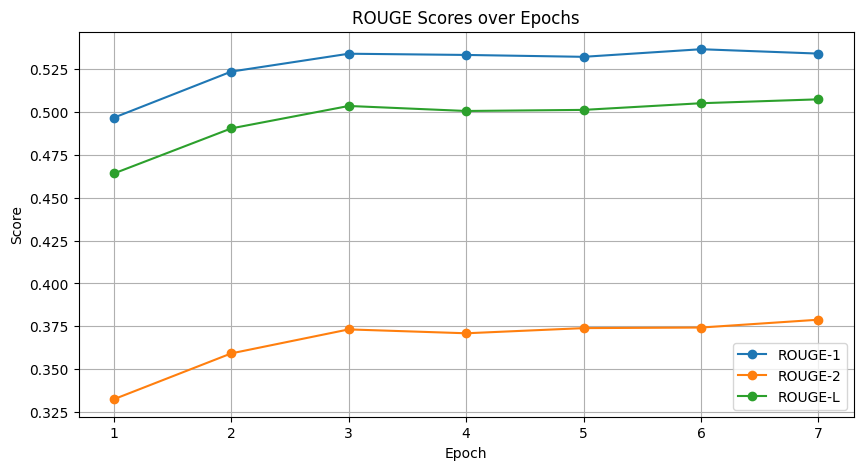

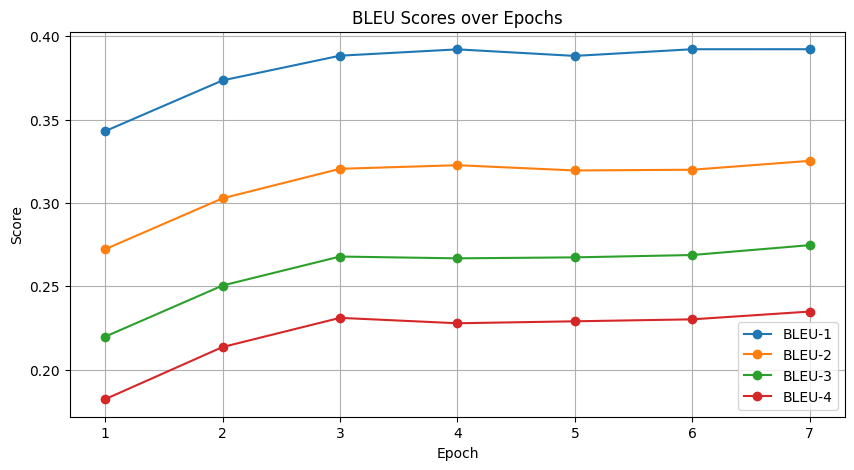

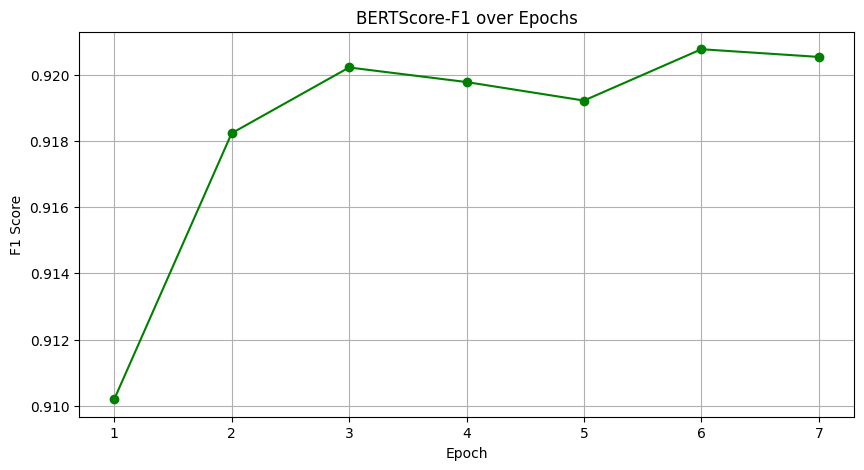

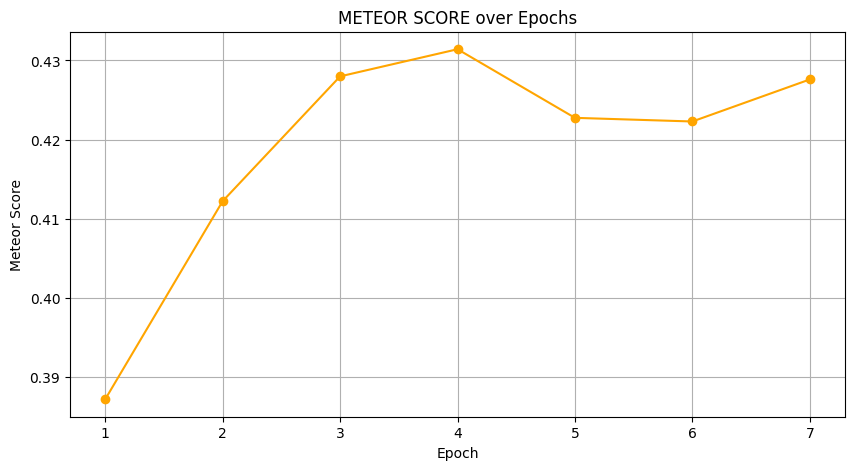

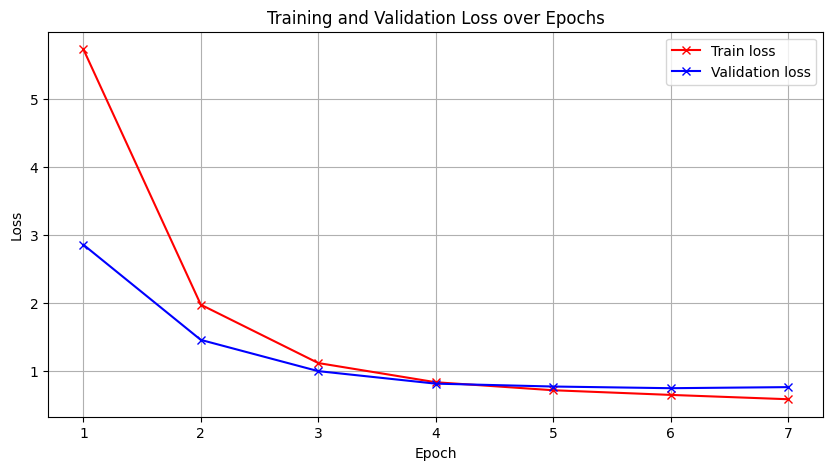

Inference: 100%|██████████| 22/22 [00:10<00:00,  2.07it/s]

Explanations saved to generated_explanations_val.json

Sample Generated Explanations (Validation Set):
PID: 707133908291231744, Explanation: <user>'s network in malad isn't awesome.
PID: 893773347026210242_185243426, Explanation: it's frustrating waiting for an hour on the tarmac for a gate to come open in snowy, windy Chicago.
PID: 708994813983596544, Explanation: the author hates the spring weather.
PID: 904624565145538560, Explanation: having a salivary gland biopsy on monday morning isn't a great way to start the new week.
PID: 697929589562146817, Explanation: it's not going to be scorching hot this w-end.


In [11]:


from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn

from nltk.translate.meteor_score import meteor_score

# Custom collate function
def custom_collate(batch):
    return {key: [d[key] for d in batch] for key in batch[0]}

# Training function
def train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, checkpoint_dir):
    model.train()
    criterion = nn.CrossEntropyLoss(ignore_index=model.tokenizer.pad_token_id)
    train_losses = []
    val_losses = []

    metrics_history = {
            "epoch": [],
            "rouge1": [],
            "rouge2": [],
            "rougeL": [],
            "bleu1": [],
            "bleu2": [],
            "bleu3": [],
            "bleu4": [],
            "bert_f1": [],
            "meteor": []
        }
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            # Prepare input data
            texts = batch['T_knowledge']
            encoding = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt")
            input_ids = encoding.input_ids.to(device)
            attention_mask = encoding.attention_mask.to(device)
            
            # Prepare visual features
            visual_feats = torch.tensor(batch['features'], dtype=torch.float32).to(device)
            
            # Prepare target labels
            target_texts = batch['explanation']
            target_encoding = model.tokenizer(target_texts, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
            labels = target_encoding.input_ids  # Raw target sequence
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, visual_feats, labels=labels)
            loss = outputs.loss  # BART computes this internally
            
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            # epoch_loss += loss.item()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")


        # Validation Phase
        model.eval()
        val_loss = 0.0
        generated_texts = []
        reference_texts = []
        with torch.no_grad():
            for batch in val_loader:
                texts = batch['T_knowledge']
                input_ids = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").input_ids.to(device)
                attention_mask = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").attention_mask.to(device)
                visual_feats = torch.tensor(batch['features'], dtype=torch.float32).to(device)
                labels = model.tokenizer(batch['explanation'], padding=True, truncation=True, max_length=128, return_tensors="pt").input_ids.to(device)
                
                outputs = model(input_ids, attention_mask, visual_feats, labels=labels)
                val_loss += outputs.loss.item()
                
                # Generate explanations
                generated_ids = model.generate_explanation(input_ids, attention_mask=attention_mask, visual_features=visual_feats, max_length=128)
                generated_texts.extend(model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True))
                reference_texts.extend(batch['explanation'])
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")
    

        # Evaluation metrics

        # Example metric tracking setup
        

        rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        rouge1, rouge2, rougeL = [], [], []
        bleu1, bleu2, bleu3, bleu4 = [], [], [], []
        meteor = []

        for gen, ref in zip(generated_texts, reference_texts):
            # ROUGE
            rouge_scores = rouge_scorer_obj.score(ref, gen)
            rouge1.append(rouge_scores['rouge1'].fmeasure)
            rouge2.append(rouge_scores['rouge2'].fmeasure)
            rougeL.append(rouge_scores['rougeL'].fmeasure)

            # BLEU
            ref_tokens = ref.split()
            gen_tokens = gen.split()
            smoothie = SmoothingFunction().method1
            bleu1.append(sentence_bleu([ref_tokens], gen_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie))
            bleu2.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
            bleu3.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie))
            bleu4.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))

            # METEOR
            # meteor.append(meteor_score([ref], gen))
            # meteor.append(meteor_score([ref.split()], gen.split(), wordnet=False))
            meteor.append(meteor_score([ref.split()], gen.split()))
            # avg_meteor = sum(meteor_scores) / len(meteor_scores)

        # BERTScore
        bert_p, bert_r, bert_f1_scores = bert_score_fn(generated_texts, reference_texts, lang="en", verbose=False)
        bert_f1 = bert_f1_scores.tolist()

        # Print averaged scores
        print(f"Epoch {epoch+1} Metrics:")
        print(f"ROUGE-1: {sum(rouge1)/len(rouge1):.4f}, ROUGE-2: {sum(rouge2)/len(rouge2):.4f}, ROUGE-L: {sum(rougeL)/len(rougeL):.4f}")
        print(f"BLEU-1: {sum(bleu1)/len(bleu1):.4f}, BLEU-2: {sum(bleu2)/len(bleu2):.4f}, BLEU-3: {sum(bleu3)/len(bleu3):.4f}, BLEU-4: {sum(bleu4)/len(bleu4):.4f}")
        print(f"METEOR: {sum(meteor)/len(meteor):.4f}, BERTScore-F1: {sum(bert_f1)/len(bert_f1):.4f}")
        # print(f"BERTScore-F1: {sum(bert_f1)/len(bert_f1):.4f}")
        metrics_history["epoch"].append(epoch+1)
        metrics_history["rouge1"].append(sum(rouge1)/len(rouge1))
        metrics_history["rouge2"].append(sum(rouge2)/len(rouge2))
        metrics_history["rougeL"].append(sum(rougeL)/len(rougeL))
        metrics_history["bleu1"].append(sum(bleu1)/len(bleu1))
        metrics_history["bleu2"].append(sum(bleu2)/len(bleu2))
        metrics_history["bleu3"].append(sum(bleu3)/len(bleu3))
        metrics_history["bleu4"].append(sum(bleu4)/len(bleu4))
        metrics_history["bert_f1"].append(sum(bert_f1)/len(bert_f1))
        metrics_history['meteor'].append(sum(meteor)/len(meteor))
        # metrics_history["train_loss"].append(avg_train_loss)  
        
        # avg_loss = epoch_loss / len(train_loader)
        # print(f"Epoch {epoch+1} Loss: {avg_loss:.4f}")
        checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch+1}.pt")
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")

    plot_metrics(metrics_history, train_losses, val_losses)



# Inference function
def inference(model, dataset, batch_size, device, output_file, generate_kwargs):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
    all_explanations = {}
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Inference"):
            texts = batch['T_knowledge']
            encoding = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
            input_ids = encoding.input_ids
            attention_mask = encoding.attention_mask
            visual_feats = torch.tensor(batch['features'], dtype=torch.float32).to(device)
            generated_ids = model.generate_explanation(input_ids, attention_mask, visual_feats, **generate_kwargs)
            generated_texts = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            for pid, explanation in zip(batch['pid'], generated_texts):
                all_explanations[pid] = explanation
    with open(output_file, "w") as f:
        json.dump(all_explanations, f, indent=2)
    print(f"Explanations saved to {output_file}")
    return all_explanations

# Main execution
if __name__ == "__main__":
    checkpoint_dir = "/kaggle/working/checkpoints"
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Data loaders
    train_loader = DataLoader(train_df.to_dict(orient="records"), batch_size=32, shuffle=True, collate_fn=custom_collate)
    val_loader = DataLoader(val_df.to_dict(orient="records"), batch_size=32, shuffle=True, collate_fn=custom_collate)
    val_dataset = val_df.to_dict(orient="records")

    # Initialize model
    model = MultimodalSarcasmExplanationModel()
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    optimizer = optim.AdamW(model.parameters(), lr=1e-5)
    scheduler = None
    num_epochs = 7

    # Train
    train_model(model, train_loader, val_loader, optimizer, scheduler, num_epochs, device, checkpoint_dir)
#     train_model(
#     model=model,
#     train_data=train_df.to_dict(orient="records"),
#     val_data=val_df.to_dict(orient="records"),
#     tokenizer=tokenizer,
#     optimizer=optimizer,
#     device=device,
#     num_epochs=5,
#     batch_size=8,
#     save_path="/kaggle/working/checkpoints"
# )
    # Inference
    generate_kwargs = {"max_length": 128, "num_beams": 4, "early_stopping": True}
    output_file = "generated_explanations_val.json"
    val_explanations = inference(model, val_dataset, batch_size=8, device=device, output_file=output_file, generate_kwargs=generate_kwargs)

    # For report: Print sample explanations (last epoch)
    print("\nSample Generated Explanations (Validation Set):")
    for pid, exp in list(val_explanations.items())[:5]:
        print(f"PID: {pid}, Explanation: {exp}")

In [ ]:
# print(nltk.__version__)

In [ ]:
# nltk.download("wordnet")

In [ ]:
# !ls /usr/share/nltk_data/corpora

In [ ]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [ ]:
# !ls /usr/share/nltk_data/corpora/wordnet.zip/

In [25]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
import bert_score
import json
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

def inference_test(model, dataset, batch_size, device, output_file, generate_kwargs, test_df):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate)
    all_explanations = {}
    all_refs = []
    all_gens = []

    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    smoothie = SmoothingFunction().method1
    rouge1, rouge2, rougeL = [], [], []
    bleu1, bleu2, bleu3, bleu4 = [], [], [], []
    meteor = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Inference"):
            texts = batch['T_knowledge']
            encoding = model.tokenizer(texts, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
            input_ids = encoding.input_ids
            attention_mask = encoding.attention_mask
            visual_feats = torch.tensor(batch['features'], dtype=torch.float32).to(device)
            
            generated_ids = model.generate_explanation(input_ids, attention_mask, visual_feats, **generate_kwargs)
            generated_texts = model.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            for pid, gen_text in zip(batch['pid'], generated_texts):
                all_explanations[pid] = gen_text
                ref_text = test_df.loc[test_df['pid'] == pid, 'explanation'].values[0]

                # Append for BERTScore later
                all_gens.append(gen_text)
                all_refs.append(ref_text)

                # ROUGE
                scores = rouge_scorer_obj.score(ref_text, gen_text)
                rouge1.append(scores['rouge1'].fmeasure)
                rouge2.append(scores['rouge2'].fmeasure)
                rougeL.append(scores['rougeL'].fmeasure)

                # BLEU
                ref_tokens = ref_text.split()
                gen_tokens = gen_text.split()
                bleu1.append(sentence_bleu([ref_tokens], gen_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie))
                bleu2.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie))
                bleu3.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothie))
                bleu4.append(sentence_bleu([ref_tokens], gen_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie))

                # METEOR
                meteor.append(meteor_score([ref_tokens], gen_tokens))

    # BERTScore
    bert_p, bert_r, bert_f1_scores = bert_score.score(all_gens, all_refs, lang="en", verbose=False)
    bert_f1 = bert_f1_scores.tolist()

    with open(output_file, "w") as f:
        json.dump(all_explanations, f, indent=2)
    print(f"Explanations saved to {output_file}")

    # Average metrics
    metrics = {
        "ROUGE-1": sum(rouge1) / len(rouge1),
        "ROUGE-2": sum(rouge2) / len(rouge2),
        "ROUGE-L": sum(rougeL) / len(rougeL),
        "BLEU-1": sum(bleu1) / len(bleu1),
        "BLEU-2": sum(bleu2) / len(bleu2),
        "BLEU-3": sum(bleu3) / len(bleu3),
        "BLEU-4": sum(bleu4) / len(bleu4),
        "METEOR": sum(meteor) / len(meteor),
        "BERTScore-F1": sum(bert_f1) / len(bert_f1)
    }

    print("\nEvaluation Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return all_explanations, metrics


In [26]:

def testing():
    model = MultimodalSarcasmExplanationModel()
    checkpoint_dir = "/kaggle/working/checkpoints"
    checkpoint_path = os.path.join(checkpoint_dir, "model_epoch_7.pt") 
    model.load_state_dict(torch.load(checkpoint_path))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()

    test_tsv = '/kaggle/input/testing/test.tsv'
    D_test_path = '/kaggle/input/testing/D_test.pkl'
    O_test_path = '/kaggle/input/testing/O_test.pkl'
    
    test_df = pd.read_csv(test_tsv, sep='\t')
    with open(D_test_path, "rb") as f1:
        D_test = pickle.load(f1)
    with open(O_test_path, "rb") as f2:
        O_test = pickle.load(f2)


    
    image_extension = ".jpg"
    test_features = []
    image_folder = "/kaggle/input/testing/images"
    
    for pid in tqdm(test_df["pid"], desc="Extracting train image features"):
        image_name = f"{pid}{image_extension}"
        image_path = os.path.join(image_folder, image_name)
        try:
            image = Image.open(image_path).convert("RGB")
            image = transform(image).unsqueeze(0).to(device)
            with torch.no_grad():
                features = vit_model(image).squeeze(0).cpu().numpy()
            test_features.append(features.tolist())
        except Exception as e:
            print(f"Error processing {image_path}: {e}")
            test_features.append([0] * 768)  # Default feature vector
    # train_df["features"] = features_column_train
    test_df["features"] = test_features

    O_test_cleaned = {}
    # O_val_cleaned = {}
    for pid, obj in O_test.items():
        class_list = obj.get("classes", []) if isinstance(obj, dict) else []
        class_list_unique = list(OrderedDict.fromkeys(class_list))
        O_test_cleaned[pid] = safe_preprocess(" ".join(class_list_unique))


    t_knowledge_col = []
    # t_knowledge_col_val = []
    for pid in test_df["pid"]:
        ci = test_df.loc[test_df["pid"] == pid, "text"].values[0]
        di = safe_preprocess(D_test.get(pid, ""))
        oi = O_test_cleaned.get(pid, "")
        ti = test_df.loc[test_df["pid"] == pid, "target_of_sarcasm"].values[0]
        t_knowledge = f"{ci} {di} {oi} </s> {ti}".strip()
        t_knowledge_col.append(t_knowledge)


    test_df["T_knowledge"] = t_knowledge_col
    test_dataset = test_df.to_dict(orient="records")
    output_file = "/kaggle/working/generated_explanations_test.json"
    # generate_kwargs = {"max_length": 128, "num_beams": 4, "early_stopping": True}
    # test_explanations = inference(model, test_dataset, batch_size=8, device=device, output_file=output_file, generate_kwargs=generate_kwargs)
    explanations, eval_metrics = inference_test(model, test_dataset, batch_size=32, device=device,
                                       output_file=output_file,
                                       generate_kwargs=generate_kwargs,
                                       test_df=test_df)
    
    return explanations, eval_metrics

In [27]:
explanations, eval_metrics = testing()

<ipython-input-26-1d2561dd7d87>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))
Inference: 100%|██████████| 6/6 [00:10<00

Explanations saved to /kaggle/working/generated_explanations_test.json

📊 Evaluation Metrics:
ROUGE-1: 0.5340
ROUGE-2: 0.3788
ROUGE-L: 0.5074
BLEU-1: 0.3922
BLEU-2: 0.3252
BLEU-3: 0.2746
BLEU-4: 0.2348
METEOR: 0.4276
BERTScore-F1: 0.9205


In [28]:
for pid, exp in list(explanations.items())[:5]:
    print(f"PID: {pid}, Explanation: {exp}\n\n")

# for key, val in list(eval_metrics.items()):
#     print(f"{key}, -- {val}")

PID: 707133908291231744, Explanation: <user>'s network in malad isn't awesome.


PID: 893773347026210242_185243426, Explanation: it's frustrating waiting for an hour on the tarmac for a gate to come open in snowy, windy Chicago.


PID: 708994813983596544, Explanation: the author hates the spring weather.


PID: 904624565145538560, Explanation: having a salivary gland biopsy on monday morning isn't a great way to start the new week.


PID: 697929589562146817, Explanation: it's not going to be scorching hot this w-end.


ROUGE-1, -- 0.5340467746275441
ROUGE-2, -- 0.378842358273001
ROUGE-L, -- 0.5073731642160458
BLEU-1, -- 0.3921988179933943
BLEU-2, -- 0.3252238088187977
BLEU-3, -- 0.27463442383880105
BLEU-4, -- 0.2348022924501645
METEOR, -- 0.4275978640892186
BERTScore-F1, -- 0.9205339642933437


In [33]:
# !zip /kaggle/working/checkpoints


zip error: Nothing to do! (/kaggle/working/checkpoints.zip)


In [41]:
# !ls /kaggle/working

checkpoints			  generated_explanations_val.json
generated_explanations_test.json  output.zip


In [35]:
# !zip -r output.zip /kaggle/working/checkpoints

  adding: kaggle/working/checkpoints/ (stored 0%)
  adding: kaggle/working/checkpoints/model_epoch_2.pt (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_5.pt (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_4.pt (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_1.pt (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_7.pt (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_6.pt (deflated 8%)
  adding: kaggle/working/checkpoints/model_epoch_3.pt (deflated 8%)


In [36]:
# %cd /kaggle/working

/kaggle/working


In [40]:
# !ls -lh

total 3.5G
drwxr-xr-x 2 root root 4.0K Apr  6 15:41 checkpoints
-rw-r--r-- 1 root root  16K Apr  6 16:41 generated_explanations_test.json
-rw-r--r-- 1 root root  16K Apr  6 15:41 generated_explanations_val.json
-rw-r--r-- 1 root root 3.5G Apr  6 17:14 output.zip


In [37]:
# from IPython.display import FileLink

# FileLink(r'output.zip')

/kaggle/working/output.zip